In [1]:
cd ../pytrader/

/Users/ashkanaleali/w/Trader/pytrader


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime as dt
import quandl
import datetime
import urllib.request, json
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from utilities import *

In [3]:
%config InlineBackend.figure_format = 'retina'

sns.set_style('darkgrid')

In [4]:
aapl = stock_data_quandl('AAPL')

In [5]:
aal = stock_data_quandl('AAL')

# Plots

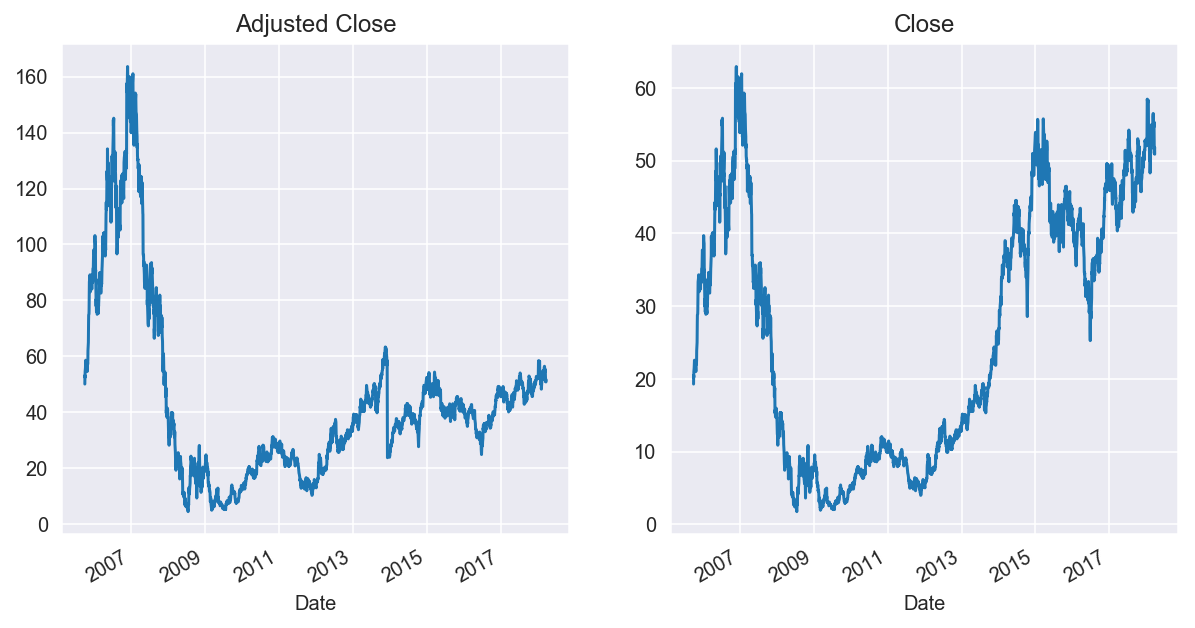

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
aal['Adj. Close'].plot(ax=axs[0], title="Adjusted Close")
aal['Close'].plot(ax=axs[1], title="Close")
plt.show()

# Traint/Test Split

In [43]:
df = aal

In [44]:
high_prices = df.loc[:, 'High'].as_matrix()
low_prices = df.loc[:, 'Low'].as_matrix()
mid_prices = (high_prices + low_prices) / 2

In [45]:
x = int(mid_prices.shape[0] / 2)
train_data = mid_prices[:x]
test_data = mid_prices[x:]

train_data = train_data.reshape(-1, 1)
test_data = test_data.reshape(-1, 1)

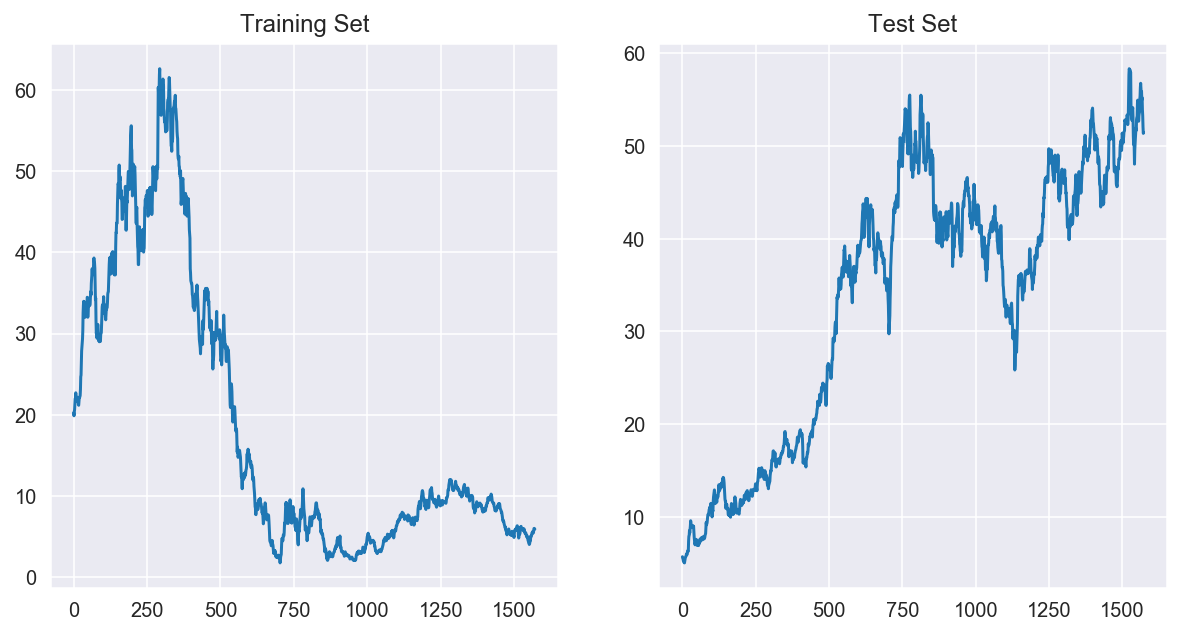

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(train_data)
axs[1].plot(test_data)

axs[0].set_title("Training Set")
axs[1].set_title("Test Set")
plt.show()

# Normalizing the data

In [47]:
def normalize_time_series(data, smoothing_window_size):
    # data of shape (m, 1)
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    
    x = len(data)
    train_data = data.copy()
    
    for di in range(0, x - smoothing_window_size, smoothing_window_size):
        scaler.fit(train_data[di:di+smoothing_window_size, :])
        train_data[di:di+smoothing_window_size,:] = scaler.transform(
            train_data[di:di+smoothing_window_size,:])

        scaler.fit(train_data[di+smoothing_window_size:, :])
        train_data[di+smoothing_window_size:, :] = scaler.transform(
            train_data[di+smoothing_window_size:, :]
        )
    
    return train_data, scaler

In [48]:
train_data_norm, scaler = normalize_time_series(train_data, 1000)

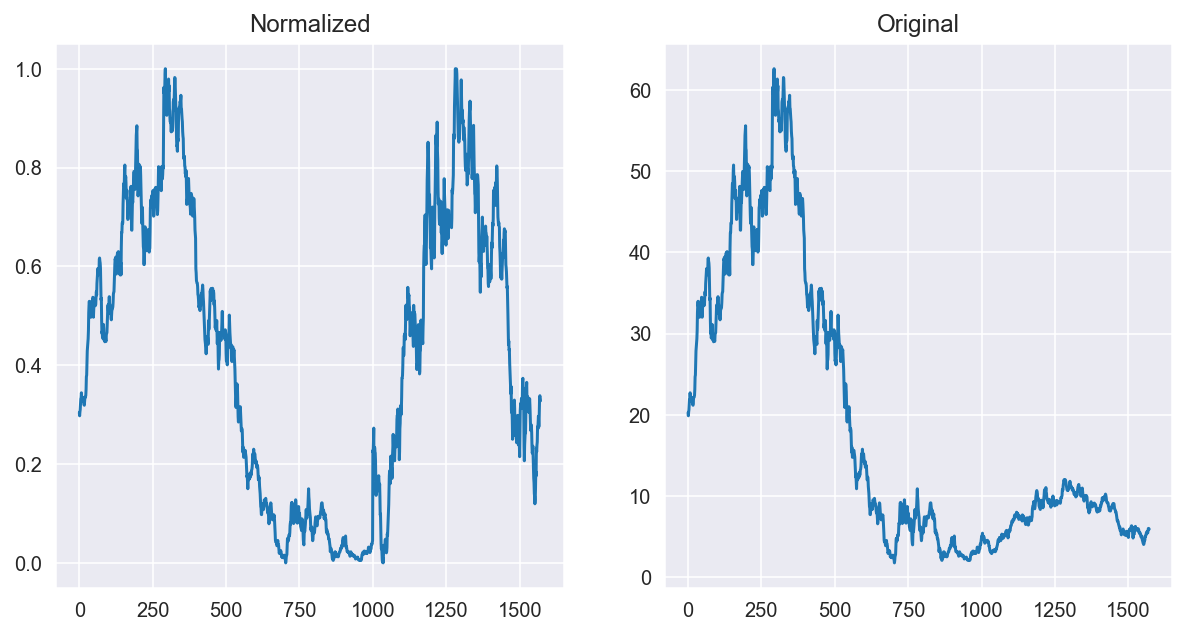

In [49]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(train_data_norm)
axs[1].plot(train_data)

axs[0].set_title("Normalized")
axs[1].set_title("Original")
plt.show()

# Exponential Moving Average

In [51]:
train_data_arr = train_data_norm.reshape(-1)
test_data_arr = scaler.transform(test_data).reshape(-1)

In [64]:
def EMA(data, gamma=0.1):
    acc = 0
    ema = np.zeros_like(data)
    x = len(data)
    for i in range(x):
        acc = gamma * data[i] + (1 - gamma) * acc
        ema[i] = acc
    return ema

In [65]:
train_data_ema = EMA(train_data_arr)

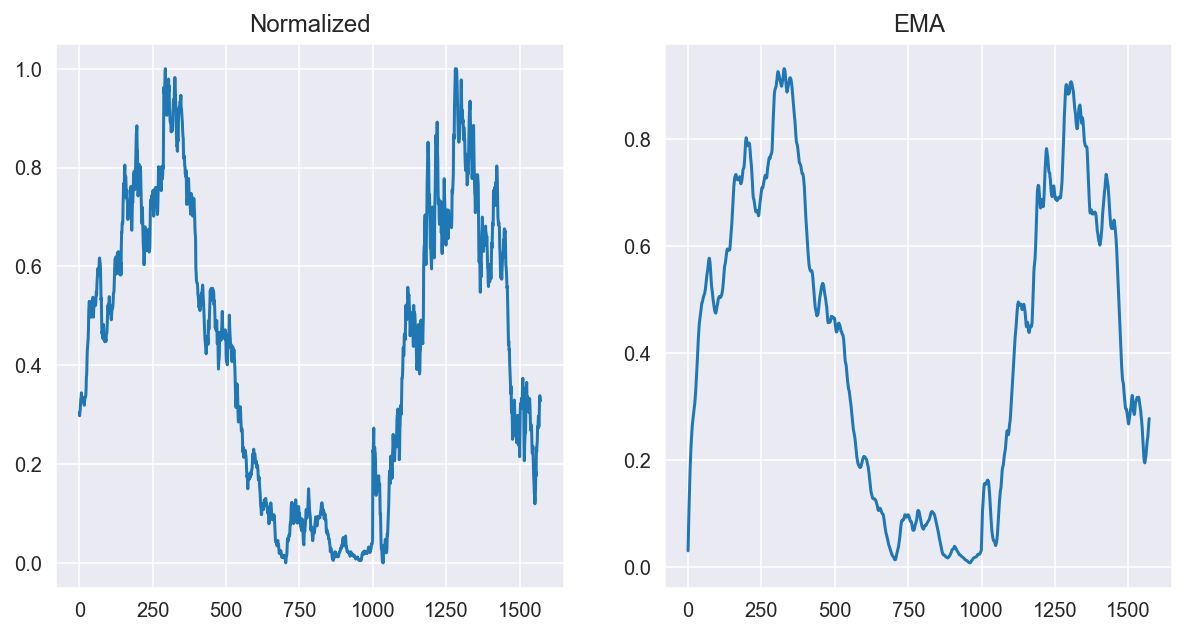

In [66]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(train_data_arr)
axs[1].plot(train_data_ema)

axs[0].set_title("Normalized")
axs[1].set_title("EMA")
plt.show()

# One-Step Ahead Prediction

## Averaging

In [68]:
list(range(1,10))

[1, 2, 3, 4, 5, 6, 7, 8, 9]

Timestamp('2005-09-28 00:00:00')

In [99]:
window_size = 5
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []
for pred_idx in range(window_size, N):
#     date = df.loc[pred_idx, 'Date']
    date = df.iloc[pred_idx, :].name
    std_avg_predictions.append(
        np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append(
        (std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

In [100]:
print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.74890


In [101]:
all_mid_data = np.concatenate([train_data,test_data],axis=0)

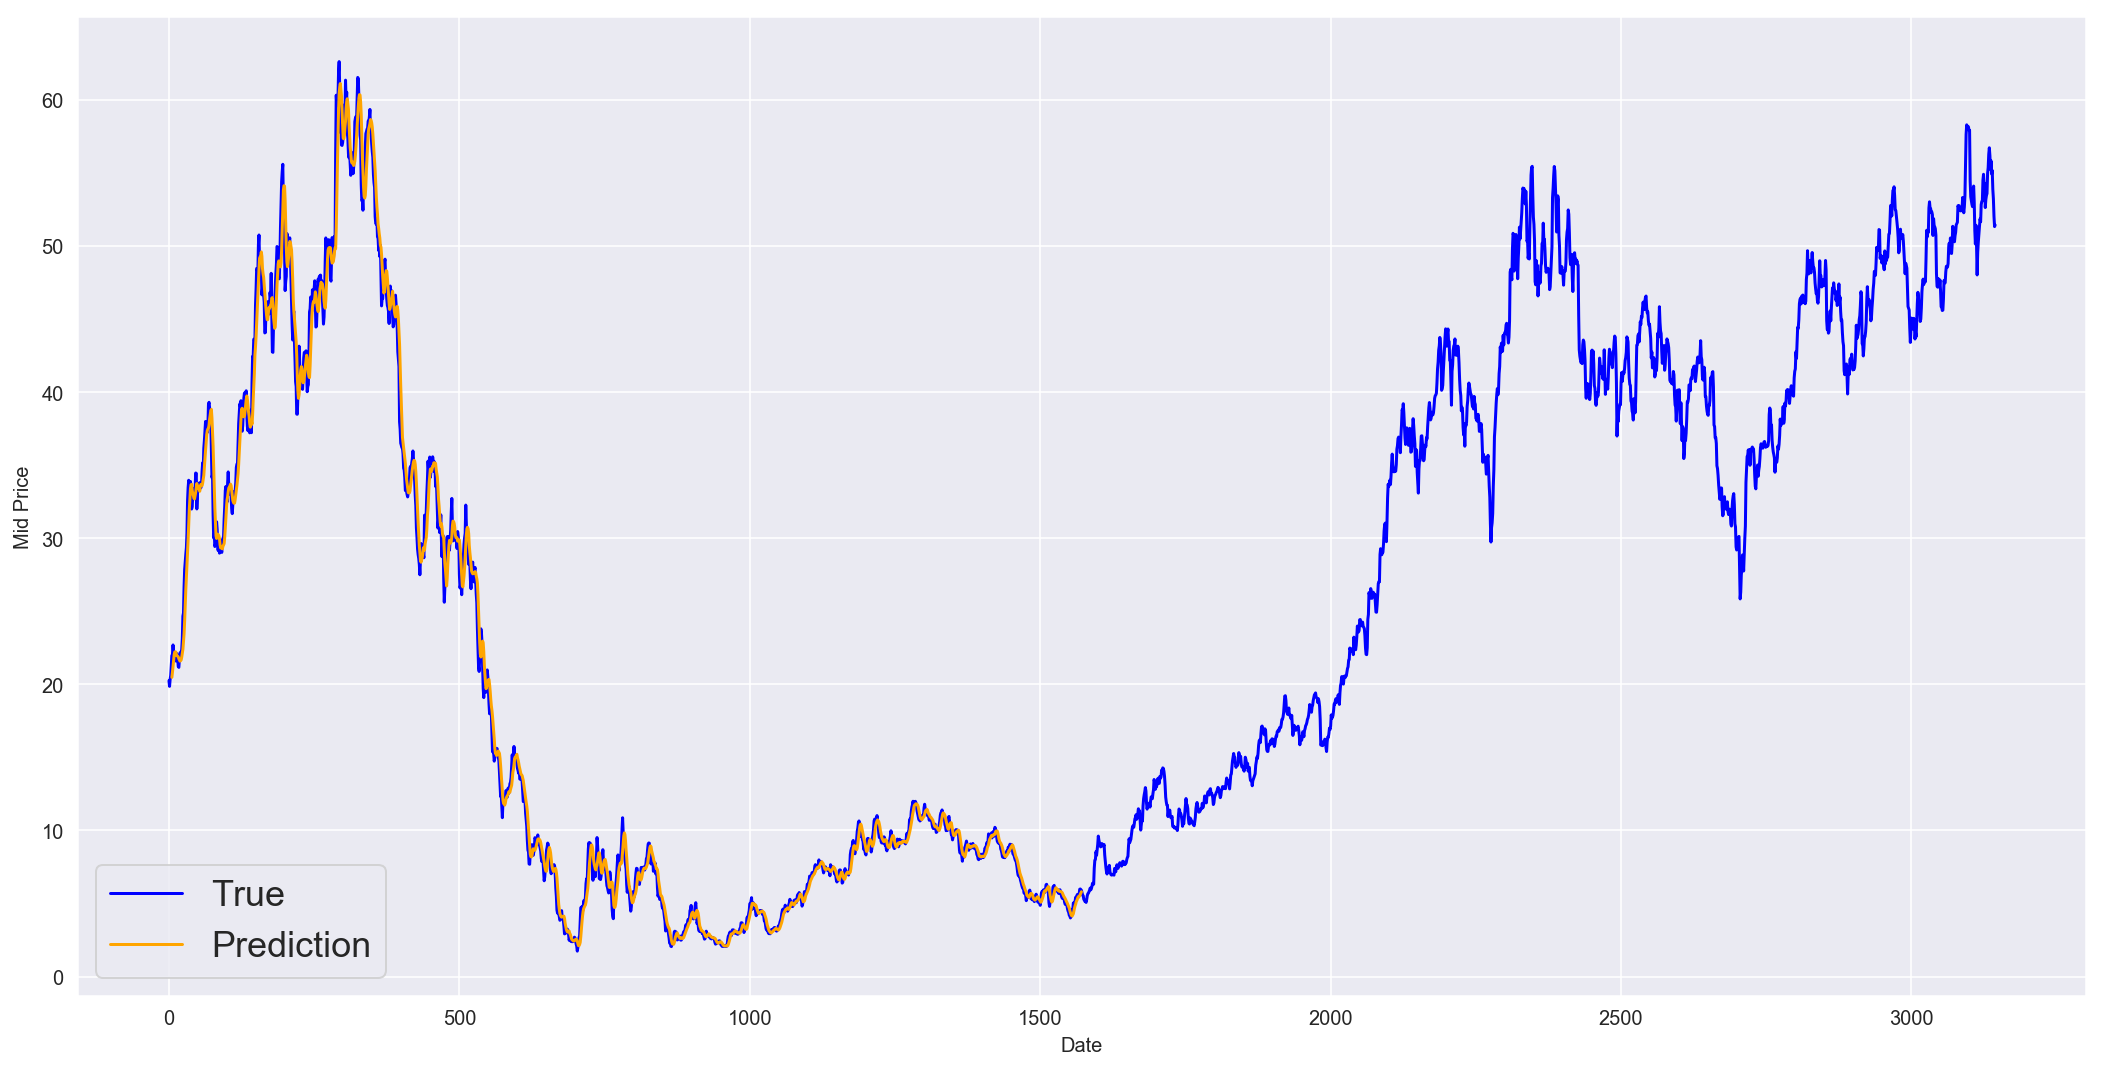

In [102]:
plt.figure(figsize = (18, 9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

## Exponential Moving Average

In [104]:
window_size = 100
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))


MSE error for EMA averaging: 0.45349


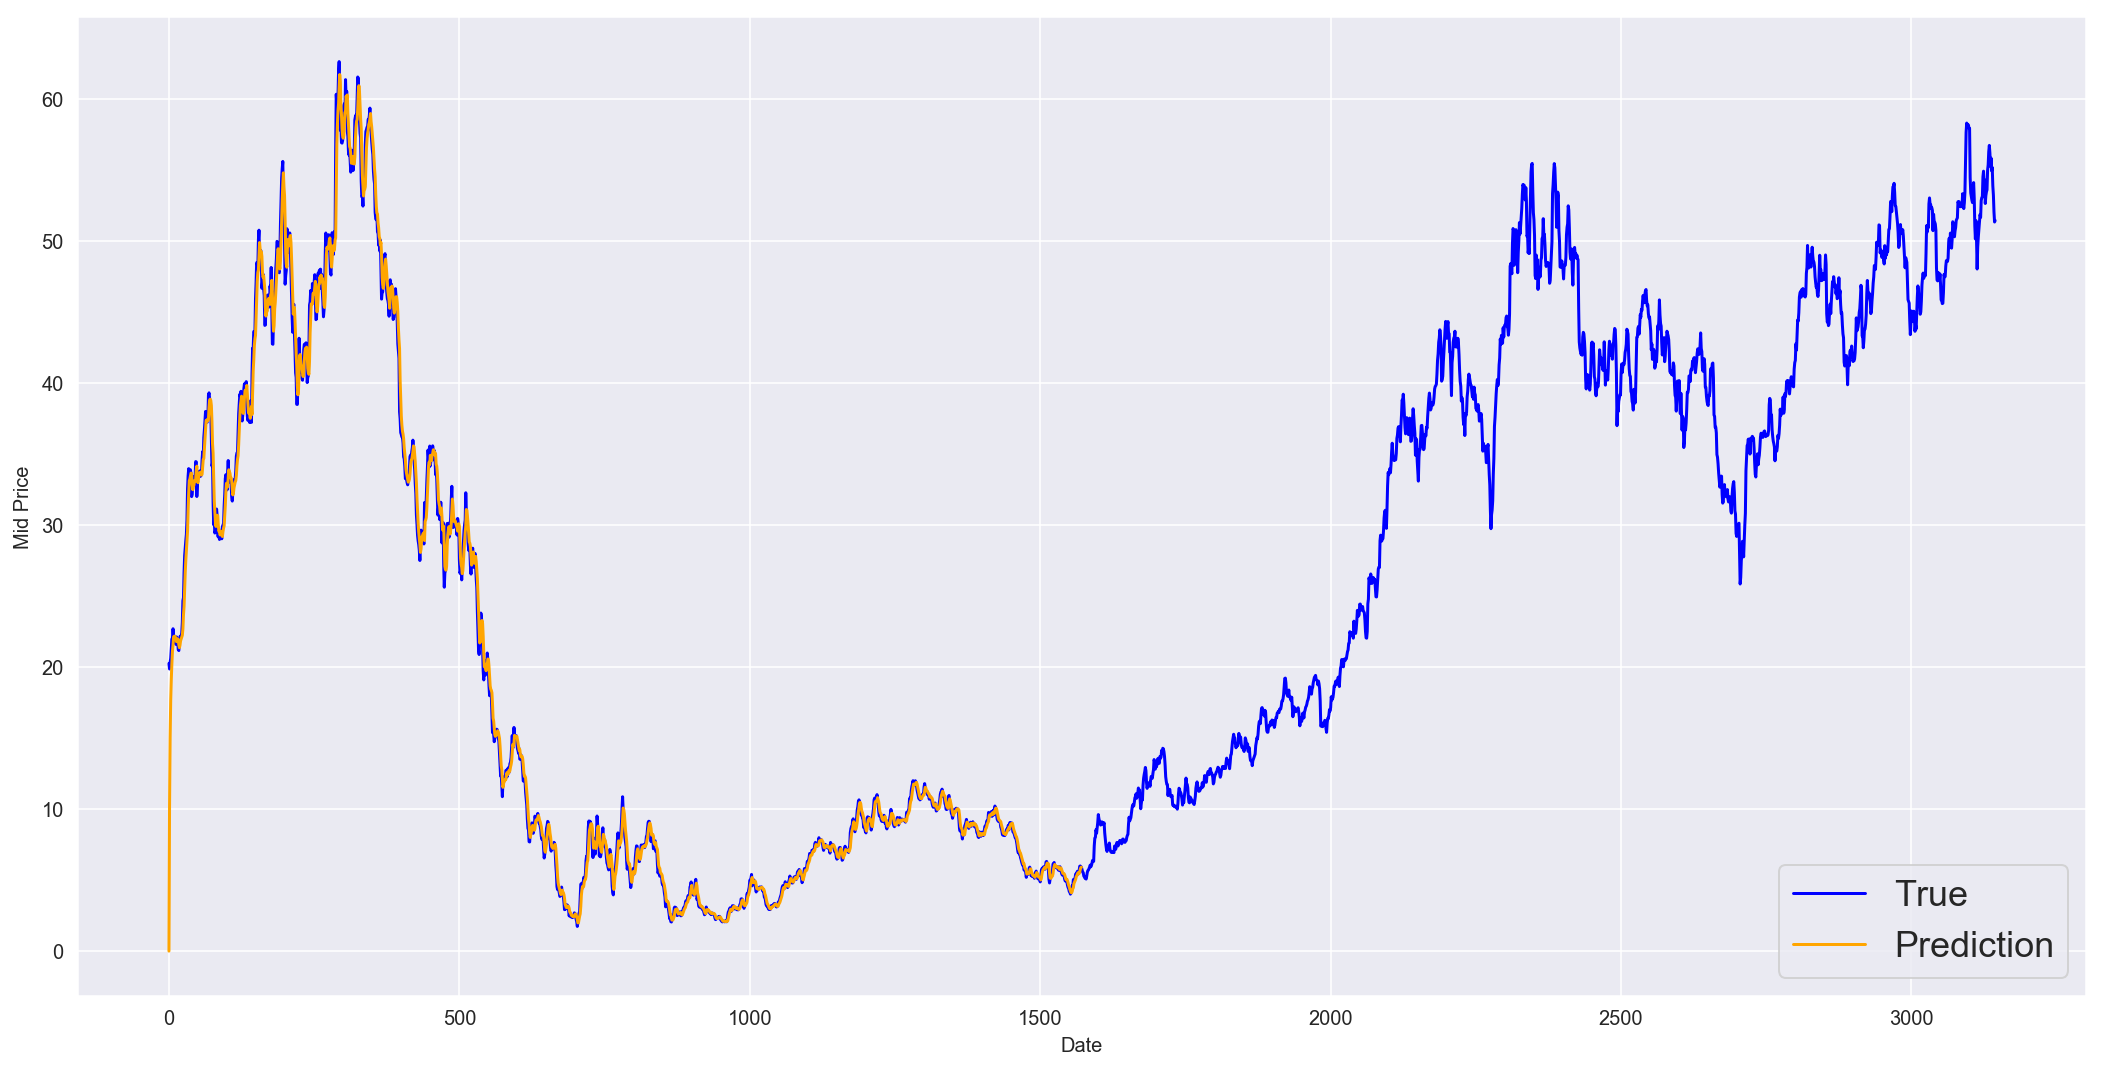

In [105]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()